# 纹理表示
纹理表示中最重要的就是通过不同的滤波器组来构建一个能够表示全图的向量。用该向量能够在一定程序上表示该图形的特征，以此对图像进行分类。
## 多种滤波器组
1. LM filters
2. Gabor-like filters
3. RFS

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from cv import conv_img

In [27]:
x = np.arange(-20, 20, 0.2)
y = np.arange(-20, 20, 0.2)
x, y = np.meshgrid(x, y)
sigma = np.array([[50, 0], [0, 10]])
z = np.zeros(shape=(x.shape))
n = 2
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        tem = np.array([x[i, j], y[i, j]]).T
        z[i, j] = (1/(2*np.pi*np.sqrt(np.linalg.det(sigma)))) * np.exp(-0.5*np.dot(np.dot(tem.T, np.linalg.inv(sigma)), tem))
print(z)

[[2.68699936e-13 2.90962758e-13 3.14818184e-13 ... 3.40357072e-13
  3.14818184e-13 2.90962758e-13]
 [4.00052296e-13 4.33198165e-13 4.68715174e-13 ... 5.06738595e-13
  4.68715174e-13 4.33198165e-13]
 [5.93237770e-13 6.42389797e-13 6.95057989e-13 ... 7.51442941e-13
  6.95057989e-13 6.42389797e-13]
 ...
 [8.76200792e-13 9.48797392e-13 1.02658730e-12 ... 1.10986679e-12
  1.02658730e-12 9.48797392e-13]
 [5.93237770e-13 6.42389797e-13 6.95057989e-13 ... 7.51442941e-13
  6.95057989e-13 6.42389797e-13]
 [4.00052296e-13 4.33198165e-13 4.68715174e-13 ... 5.06738595e-13
  4.68715174e-13 4.33198165e-13]]


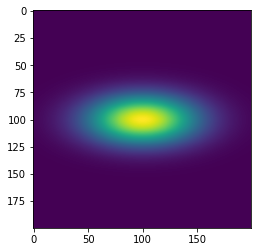

In [28]:
plt.imshow(z)

In [32]:
def gaussian1d(sigma, mean, x, ord):
    x = np.array(x)
    x_ = x-mean
    var = sigma ** 2
    g1 = (1/np.sqrt(2*np.pi*var)) * (np.exp((-1*x_*x_)/(2*var)))
    if ord == 0:
        g = g1
        return g
    elif ord == 1:
        g = -g1*((x_)/(var))
        return g
    else:
        g = g1*(((x_*x_) - var)/(var**2))
    return g

def log2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    h = g*((x*x + y*y) - var)/(var**2)
    return h

def gaussian2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    return g

def makefilter(scale, phasex, phasey, pts, sup):
    gx = gaussian1d(3*scale, 0, pts[0, :], phasex)
    gy = gaussian1d(scale, 0, pts[1, :], phasey)
    image = gx*gy
    image = np.reshape(image, (sup, sup))
    return image

In [41]:
# LMfilters
SUP = 49 # 最大的滤波器长度
SCALEX = np.sqrt(2)**np.arange(1, 4, 1)
NORIENT = 6 # 方向个数
NROTINV = 12
NBAR = len(SCALEX) * NORIENT
NEDGE = len(SCALEX) * NORIENT
NF = NBAR+NEDGE+NROTINV
F = np.zeros(shape=(SUP, SUP, NF))
hsup = (SUP-1) // 2
x, y = np.meshgrid(np.arange(-hsup, hsup+1), np.arange(-hsup, hsup+1))
orgpts = np.array([x.flatten(), y.flatten()])
count = 0
for scale in range(len(SCALEX)):
    for orient in range(NORIENT):
        angle = (np.pi * orient) / NORIENT
        c = np.cos(angle)
        s = np.sin(angle)
        rotpts = [[c, -s], [s, c]]
        rotpts = np.array(rotpts)
        rotpts = np.dot(rotpts, orgpts)
        F[:, :, count] = makefilter(SCALEX[scale], 0, 1, rotpts, SUP)
        F[:, :, count+NEDGE] = makefilter(SCALEX[scale], 0, 2, rotpts, SUP)
        count += 1

count = NBAR + NEDGE
scales = np.sqrt(2) ** np.arange(1, 5)
for i in range(len(scales)):
    F[:, :, count] = gaussian2d(SUP, scales[i])
    count += 1
for i in range(len(scales)):
    F[:, :, count] = log2d(SUP, scales[i])
    count += 1
for i in range(len(scales)):
    F[:, :, count] = gaussian2d(SUP, scales[i])
    count += 1

In [42]:
print(count)

48


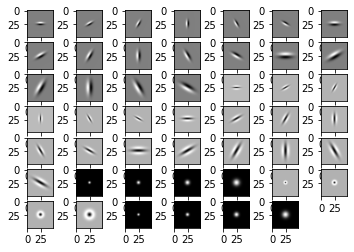

In [53]:
figure = plt.figure()
for i in range(count):
    plt.subplot(7, 7, i+1)
    plt.imshow(F[:, :, i], cmap="gray")

(600, 400)


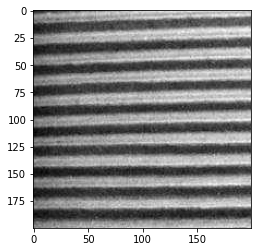

In [71]:
img = plt.imread(r"./texture-1.jpg")
a, b, c = img.shape
new_img = np.zeros(shape=(a, b))
print(new_img.shape)
for i in range(a):
    for j in range(b):
        new_img[i, j] = img[i, j].mean()
new_img = new_img[:200, :200]
plt.imshow(new_img, cmap="gray")

In [72]:
conv_img_list = []
for i in range(48):
    conv_img_list.append(conv_img(new_img, F[:,:, i]))

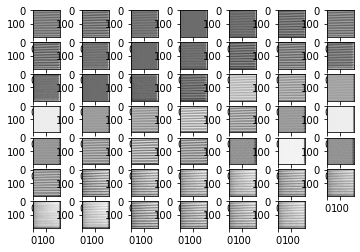

In [76]:
figure = plt.figure()
for i in range(count):
    plt.subplot(7, 7, i+1)
    plt.imshow(conv_img_list[i], cmap="gray")

0.9148847675601998
33


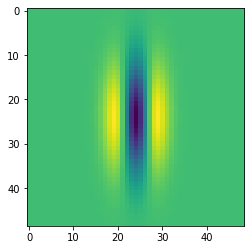

In [93]:
hog = []
for i in range(48):
    min_val = np.min(conv_img_list[i])
    max_val = np.max(conv_img_list[i])
    hog.append(np.mean(np.abs((conv_img_list[i]-min_val) / (max_val - min_val))))
hog = np.array(hog)
idx = np.argmax(hog)
print(np.max(hog))
print(idx)
plt.imshow(F[:, :, idx])

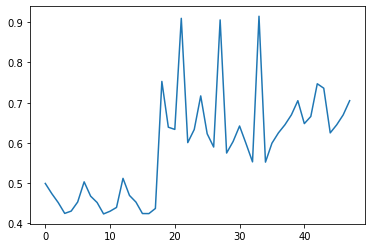

In [94]:
plt.plot(hog)

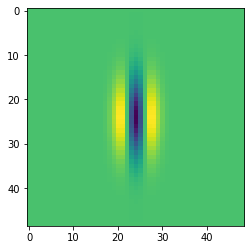

In [98]:
plt.imshow(F[:, :, 27])

In [95]:
np.max(conv_img_list[33])

0.222453569262619

In [87]:
np.mean(np.abs((conv_img_list[i]-np.min(conv_img_list[i]) / (np.max(conv_img_list[i] - np.min(conv_img_list[i]))))))

1221.528382910275

In [92]:
min_val = np.min(conv_img_list[i])
max_val = np.max(conv_img_list[i])
(conv_img_list[i]-min_val) / (max_val - min_val)

1595.8841148617594 327.6993502212942


array([[0.        , 0.04662856, 0.08971954, ..., 0.25357404, 0.19210035,
        0.12466334],
       [0.05322478, 0.1093431 , 0.16114879, ..., 0.33425089, 0.26298146,
        0.18485056],
       [0.10434272, 0.16952675, 0.22963295, ..., 0.4020326 , 0.32248835,
        0.23534594],
       ...,
       [0.11816539, 0.18563649, 0.24756144, ..., 0.38869735, 0.31122966,
        0.22605498],
       [0.08031482, 0.14100835, 0.19673008, ..., 0.32168368, 0.25228808,
        0.17596811],
       [0.03485166, 0.08739658, 0.13564887, ..., 0.24205752, 0.18226416,
        0.11647226]])